In [1]:
# install.packages("Rcpp")

In [2]:
library(Rcpp)

Warning message:
"package 'Rcpp' was built under R version 3.6.3"

#### 1. Calculate Squared Distance

$D = dist2(X, C)$ takes two matrices of vectors and calculates the squared Euclidean distance between them.  Both matrices must be of the same column dimension.  If $X$ has $M$ rows and $N$ columns, and $C$ has $L$ rows and $N$ columns, then the result has $M$ rows and $L$ columns.  The $i$, $j$th entry is the  squared distance from the $i$th row of $X$ to the $j$th row of $C$.

In [3]:
dist2 <- function(x, c) {
    # Get the number of data points and dimensions in x
    ndata <- nrow(x)
    dimx <- ncol(x)
    
    # Get the number of centres and dimensions in c
    ncentres <- nrow(c)
    dimc <- ncol(c)
    
    # Check that the dimensions of x and c match
    if (dimx != dimc) {
        stop("Data dimension does not match dimension of centres")
    }
    
    # Calculate the squared Euclidean distance between each data point in x and each centre in c
    n2 <- matrix(0, nrow = ndata, ncol = ncentres)
    for (i in 1:ncentres) {
        n2[, i] <- colSums((t(x) - t(c)[,i])^2)
    }
    
    #n2 <- matrix(rowSums(x^2), ndata, 1) %*% matrix(rep(1, ncentres), ncol = ncentres) + 
    #      matrix(rep(rowSums(c), ndata), ncol = ncentres, byrow = TRUE) -
    #      2 * x %*% t(c)
    
    # Return the squared Euclidean distance matrix
    return(n2)
}

In [4]:
# install.packages('fields')

In [5]:
set.seed(1)
x <- matrix(rnorm(2*3, mean=2, sd=2), nrow=2)
c <- matrix(runif(5*3), nrow=5)

# Use r built-in distance function to check if the above calculation is correct
library(fields)
print(paste0('Number of different elements from two distance matrices calculated is ', sum((round(dist2(x, c),2) == round(rdist(x,c)^2, 2)) == FALSE)))

Warning message:
"package 'fields' was built under R version 3.6.3"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.6.3"Loading required package: dotCall64
Warning message:
"package 'dotCall64' was built under R version 3.6.3"Loading required package: grid
Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


[1] "Number of different elements from two distance matrices calculated is 0"


#### 2. Cost Function

In [6]:
hist_cost_2 <- function(BH1, BH2, eps=0.001) {
    # same as hist_cost.m but BH1 and BH2 can be of different lengths
    nsamp1 <- dim(BH1)[1]
    nbins <- dim(BH1)[2]
    nsamp2 <- dim(BH2)[1]
    
    BH1n <- BH1 / matrix(rep(rowSums(BH1)+eps, nbins), nrow=nsamp1, byrow=F)
    BH2n <- BH2 / matrix(rep(rowSums(BH2)+eps, nbins), nrow=nsamp2, byrow=F)
    
    tmp1 <- array(rep(BH1n, each=nsamp2), dim=c(nsamp1, nsamp2, nbins))
    tmp2 <- array(rep(t(BH2n), each=nsamp1), dim=c(nsamp1, nsamp2, nbins))
    
    HC <- 0.5 * apply((tmp1 - tmp2)^2 / (tmp1 + tmp2 + eps), c(1, 2), sum)
    return(HC)
}

#### 3. Sample Sequence from Designated Points

In [7]:
# Sample sequence from designated points
# Given: the sequence of feature points
# Return: subsequences
samplingSequencesIdx <- function(sensordata, seqlen, idx) {
  # Check if the correct number of arguments have been provided
  if(missing(idx)) {
    stop("Insufficient number of arguments")
  }
  
  # Get the number of timestamps and dimensions
  nTimeStamps <- nrow(sensordata)
  nDims <- ncol(sensordata)
  
  # Check if the input matrix is in the correct format
  if(nTimeStamps < nDims) {
    warning("Synchronized signals should be arranged column-wisely\n")
  }
  
  # Initialize variables
  mask <- 1:seqlen
  mask <- mask - ceiling(seqlen/2)
  nSeqs <- length(idx)
  sequences <- list()
  tAnchor <- idx
  cnt <- 0
  
  # Loop through each subsequence
  for(i in 1:nSeqs) {
    iloc <- idx[i]
    imask <- mask + iloc
    
    # Check if the subsequence is within the bounds of the input matrix
    if(imask[1] <= 0 && imask[length(imask)] <= nTimeStamps) {
      tmp <- matrix(rep(sensordata[1, ], (1-imask[1])*nDims), ncol=nDims, byrow=TRUE)
      isequence <- rbind(tmp, sensordata[1:imask[length(imask)], ])
    } 
    else if(imask[length(imask)] > nTimeStamps && imask[1] >= 1) {
      tmp <- matrix(rep(sensordata[nTimeStamps, ], (imask[length(imask)]-nTimeStamps)*nDims), ncol=nDims, byrow=TRUE)
      isequence <- rbind(sensordata[imask[1]:nTimeStamps, ], tmp)
    } 
    else if(imask[1] <= 0 && imask[length(imask)] > nTimeStamps) {
      tmp1 <- matrix(rep(sensordata[1, ], (1-imask[1])*nDims), ncol=nDims, byrow=TRUE)
      tmp2 <- matrix(rep(sensordata[nTimeStamps, ], (imask[length(imask)]-nTimeStamps)*nDims), ncol=nDims, byrow=TRUE)
      isequence <- rbind(tmp1, sensordata, tmp2)
    } 
    else {
      isequence <- sensordata[imask, ]
    }
    
    cnt <- cnt + 1
    tAnchor[cnt] <- iloc
    sequences <- rbind(sequences, list(isequence))
  }
  
  tAnchor <- tAnchor[1:cnt]
  
  return(list(sequences, tAnchor))
}

In [8]:
# Read data from file
data_urc <- read.table('../../data/dataSet_URC.txt', quote="\"", comment.char="")[,2:10]
samplingSequencesIdx(data_urc, 5, c(3:5))

"0.4248307, 0.6525383, 0.4046725, 1.0870582, 0.4436209, 1.4173710, 2.1728969, 0.5536035, 2.0101909, 0.9472850, 2.6664697, 3.6374980, 0.7235771, 2.2997473, 1.9240844, 3.2957564, 2.2746095, 1.4479759, 1.6287423, 2.1597897, 2.2625860, 0.9763371, 2.0111302, 0.6360933, 1.4994468, 0.1650483, -0.3876330, 1.6232818, -0.1405643, 0.9645078, -0.9588735, -0.9102164, 1.2038459, 0.5473488, 0.2232562, 0.2824344, -0.1481396, 1.1166959, 1.0740507, -0.4249456, 0.8421263, 0.3047345, 0.5617010, 0.8959816, 0.1212787"
"0.652538270, 0.404672490, 1.087058200, 0.443620910, 0.209288520, 2.172896900, 0.553603530, 2.010190900, 0.947285030, 1.272233300, 3.637498000, 0.723577080, 2.299747300, 1.924084400, 2.821823100, 2.274609500, 1.447975900, 1.628742300, 2.159789700, 3.589123700, 0.976337080, 2.011130200, 0.636093330, 1.499446800, 2.221711100, -0.387633030, 1.623281800, -0.140564330, 0.964507760, 0.569911390, -0.910216450, 1.203845900, 0.547348750, 0.223256230, -0.937877270, -0.148139590, 1.116695900, 1.074050700, -0.424945600, -0.812020570, 0.304734520, 0.561700960, 0.895981570, 0.121278670, -0.009299545"
"0.404672490, 1.087058200, 0.443620910, 0.209288520, 1.084084500, 0.553603530, 2.010190900, 0.947285030, 1.272233300, 1.852098600, 0.723577080, 2.299747300, 1.924084400, 2.821823100, 1.832584200, 1.447975900, 1.628742300, 2.159789700, 3.589123700, 1.548627700, 2.011130200, 0.636093330, 1.499446800, 2.221711100, 1.381758000, 1.623281800, -0.140564330, 0.964507760, 0.569911390, 1.000645300, 1.203845900, 0.547348750, 0.223256230, -0.937877270, 0.254974440, 1.116695900, 1.074050700, -0.424945600, -0.812020570, -0.332783530, 0.561700960, 0.895981570, 0.121278670, -0.009299545, -0.444037440"


#### 4. Dynamic Programming

In [9]:
sourceCpp("dpcore.cpp")

In [10]:
# [p,q,D,sc] = dpfast(M,C,T,G)
#    Use dynamic programming to find a min-cost path through matrix M.
#    Return state sequence in p,q; full min cost matrix as D and 
#    local costs along best path in sc.
#    This version gives the same results as dp.m, but uses dpcore.mex
#    to run ~200x faster.
#    C is a step matrix, with rows (i step, j step, cost factor)
#    Default is [1 1 1.0;0 1 1.0;1 0 1.0];
#    Another good one is [1 1 1;1 0 1;0 1 1;1 2 2;2 1 2]
#    T selects traceback origin: 0 is to any edge; 1 is top right (default);
#    T > 1 finds path to min of anti-diagonal T points away from top-right.
#    Optional G defines length of 'gulleys' for T=0 mode; default 0.5
#    (i.e. accept path to only 50% of edge nearest top-right)
# 2003-04-04,2005-04-04 dpwe@ee.columbia.edu $Header: /Users/dpwe/projects/dtw/RCS/dpfast.m,v 1.6 2008/03/14 14:40:50 dpwe Exp dpwe $
  
  # Copyright (c) 2003 Dan Ellis <dpwe@ee.columbia.edu>
  # released under GPL - see file COPYRIGHT

dpfast <- function(M, C=c(1,1,1.0), window_size=1, T=1, G=0.5) {
    if (missing(M)) {
        stop("Error: M is missing")
    }
    
    # Default step / cost matrix
    if (missing(C)) {
        C = matrix(c(1, 1, 1.0, 0, 1, 1.0, 1, 0, 1.0), ncol=3, byrow=TRUE)
    }
    
    # Default: path to top-right
    if (missing(T)) {
        T = 1
    }
    
    # how big are gulleys?
    if (missing(G)) {
        G = 0.5  # half the extent
    }
    
    if (sum(is.nan(M)) > 0) {
        stop("Error: Cost matrix includes NaNs")
    }
    
    if (min(M) < 0) {
    warning("Warning: cost matrix includes negative values; results may not be what you expect")
    }
    
    r <- nrow(M)
    c <- ncol(M)
    
    # Core cumulative cost calculation coded as mex
    D_phi <- dpcore_window(M, C, window_size)
    D <- D_phi$D
    phi <- D_phi$phi
    
    p <- NULL
    q <- NULL
    
    ## Traceback from top left?
    i <- r
    j <- c
#     if (T == 0) {
#         # Traceback from lowest cost "to edge" (gulleys)
#         TE <- D[r,]
#         RE <- D[,c]
#         # eliminate points not in gulleys
#         TE[1:round((1-G)*c)] <- max(D)
#         RE[1:round((1-G)*r)] <- max(D)
#         if (min(TE) < min(RE)) {
#             i <- r
#             j <- max(which(TE==min(TE)))
#         } else {
#             i <- max(which(RE==min(RE)))
#             j <- c
#         }
#     } else {
#         if (min(dim(D)) == 1) {
#             # degenerate D has only one row or one column - messes up diag
#             i <- r
#             j <- c
#         } else {
#             # Traceback from min of antidiagonal
#             #stepback = floor(0.1*c)
#             stepback <- T
#             DD = D[, c:1]
#             slice <- DD[row(DD) == col(DD)+(r-stepback)]
#             ii <- which.min(slice)
#             i <- r - stepback + ii
#             j <- c + 1 - ii
#         }
#     }
    
    p <- i
    q <- j
    sc <- c()
    
    while (i >= 1 && j >= 1) {
        if (i == 1 && j == 1) {
            break
        }
        #disp(paste0("i=",i," j=",j))
        tb <- phi[i, j]
        sc <- c(M[i, j] * C[tb, 3], sc)
        i <- i - C[tb, 1]
        j <- j - C[tb, 2]
        p <- c(i, p)
        q <- c(j, q)  
    }
    sc <- c(M[i, j], sc)
    
    return(list(p=p, q=q, D=D, sc=sc))
}

In [11]:
# Test dpfast and dpcore
nrow = 10
ncol = 9
M = matrix(abs(rnorm(nrow * ncol)), nrow=nrow, ncol=ncol)
C = rbind(c(1, 1, 1), c(1, 0, 1), c(0, 1, 1))
dpfast(M, C, window_size=4)

ERROR: Error in dpcore_window(M, C, window_size): 没有"dpcore_window"这个函数


In [12]:
sourceCpp("dist2.cpp")

In [13]:
x = matrix(c(1, 2, 3, 4, 5, 6), ncol = 3)
c = matrix(c(1, 2, 3), ncol = 3)
x
c

1,3,5
2,4,6


1,2,3


In [14]:
dist2(x, c)

5
14


In [15]:
sourceCpp("dpcore_window.cpp")

In [16]:
dpcore_window(M, C, 5)

0.2992151,0.3563219,1.083073,2.249643,2.304521,3.119489,0.000000,0.000000,0.000000
0.7107260,0.8028231,1.508234,2.148663,2.398805,2.546784,3.647753,0.000000,0.000000
0.9629494,1.7964953,1.794983,3.072016,2.766907,3.823903,2.690556,3.687542,0.000000
1.8548705,1.6539032,2.083416,2.951520,2.939530,3.132848,2.808309,2.966334,4.422322
2.2905538,2.9385026,2.892207,2.915463,5.139364,3.187943,3.720378,4.064328,3.195353
3.5280922,2.3372800,2.616626,2.843955,4.107569,3.253231,4.625529,4.367052,4.191897
0.0000000,2.5729866,4.095183,2.882764,3.202684,3.221840,4.018930,5.318242,4.973756
0.0000000,0.0000000,3.133733,3.259466,2.893809,3.151147,4.405231,4.892192,5.668969
0.0000000,0.0000000,0.000000,5.575097,3.834458,3.542819,3.923290,3.931661,4.547651
0.0000000,0.0000000,0.000000,0.000000,3.950284,3.661988,3.762335,4.643207,3.978241
0,3,3,3,3,3,0,0,0


#### 5. Shape Descriptors

In [50]:
calcDescriptor <- function(subsequence, descriptorName = "HOG1D", param = NULL) {
  if (ncol(subsequence) != 1) {
    stop("The input subsequence should be one-dimensional\n")
  }
  
  if (missing(param)) {
    param <- validateHOG1Dparam()
  }
  
  switch(descriptorName,
         "HOG1D" = {
           val_param <- validateHOG1Dparam(param)
           descriptor <- descriptorHOG1D(subsequence, val_param)
         },
         "PAA" = {
           val_param <- validatePAAdescriptorparam(param)
           descriptor <- descriptorPAA(subsequence, val_param)
         },
         "DWT" = {
           val_param <- validateDWTdescriptorparam(param)
           descriptor <- descriptorDWT(subsequence, val_param)
         },
         stop("Only support 3 descriptors\n")
  )
  
  return(descriptor)
}

## Test Descriptors

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[1] 312   3


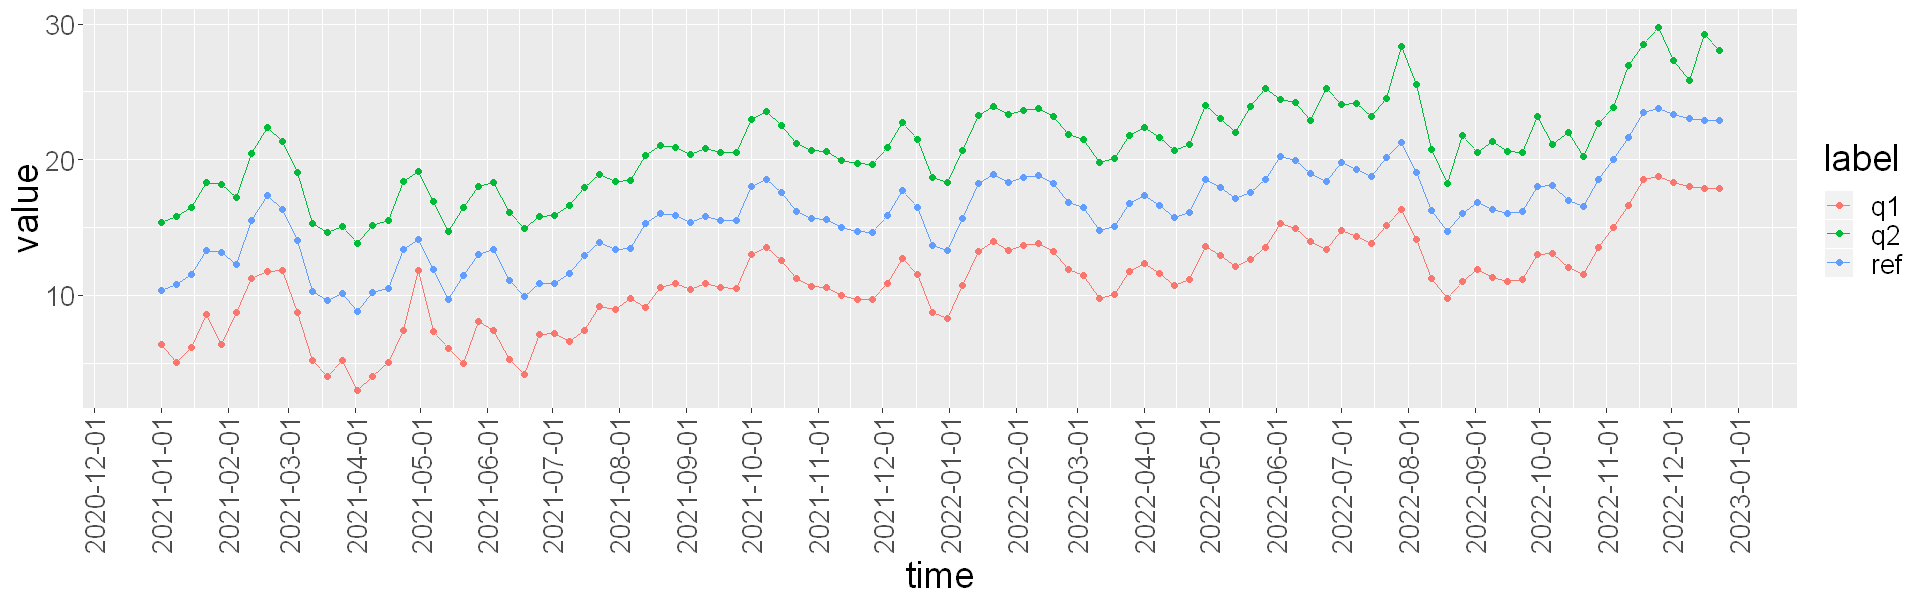

In [24]:
library(data.table)
library(ggplot2)
dt <- fread('../testdata.csv')
dt[, time := as.Date(time)]
print(dim(dt))

options(repr.plot.width = 16, repr.plot.height = 5)
ggplot(data=dt, aes(x=time, y=value, color=label)) + geom_point() + geom_line() + 
scale_x_date(breaks='1 month') + theme(
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1),
    axis.title=element_text(size=22), axis.text=element_text(size=16), 
    legend.title=element_text(size=22), legend.text=element_text(size=16))

In [25]:
head(dt)

time,label,value
2021-01-01,ref,10.37722
2021-01-08,ref,10.79246
2021-01-15,ref,11.50489
2021-01-22,ref,13.33110
2021-01-29,ref,13.13147
2021-02-05,ref,12.24382


In [29]:
ref = dt[label == "ref"]

In [78]:
ref_value = dt[label == "ref"]$value

In [79]:
typeof(ref_value)

[1] "double"

In [80]:
ref_value2 = matrix(c(ref_value), ncol=1)

In [81]:
ref_value2

10.377223
10.792458
11.504895
13.331097
13.131473
12.243818
15.484723
17.388900
16.352631
14.032310
10.293315


In [82]:
dim(ref_value2)

[1] 104   1

In [55]:
calcDescriptor(ref_value, descriptorName = "HOG1D", param = NULL)

ERROR: Error in descriptorHOG1D(subsequence, val_param): 没有"descriptorHOG1D"这个函数


In [56]:
source("descriptorPAA.R")

In [58]:
source("validatePAAdescriptorparam.R")

In [88]:
source("PAA.R")

In [89]:
calcDescriptor(ref_value2, descriptorName = "PAA", param = NULL)

$rep
 [1] 13.46395 10.85586 11.89908 15.43755 16.14741 17.03609 16.43503 18.77192
 [9] 17.55217 20.38234

$segLens
 [1] 10 10 10 10 10 10 10 10 10 14

$idx_seg
 [1]   0  10  20  30  40  50  60  70  80  90 104

$val_params
$val_params$priority
[1] "segNum"

$val_params$segNum
[1] 10

$val_params$segLen
[1] 10

In [99]:
source("descriptorHOG1D.R")
source("validateHOG1Dparam.R")

In [91]:
utility_fcn_list <- c("descriptorHOG1D.R", "validateHOG1Dparam.R")
sapply(utility_fcn_list, source)

descriptorHOG1D.R                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
value   function (sequences,

In [96]:
install.packages("eyelinker")

also installing the dependency 'intervals'




  There are binary versions available but the source versions are later:
          binary source needs_compilation
intervals 0.15.2 0.15.3              TRUE
eyelinker  0.2.0  0.2.1             FALSE



installing the source packages 'intervals', 'eyelinker'



In [97]:
library("eyelinker")

In [106]:
source("whichInterval.R")

In [141]:
# path_est <- "W:/UMN/Dissertation/LocalMarket/Estimation/"
# fcn_list <- list.files(path = file.path(path_est, "mlogit_lib"), pattern = "[[:alpha:]]*.R")
lib <- sapply(c("descriptorHOG1D.R", "validateHOG1Dparam.R"), function(x) source(x, echo = FALSE))

In [142]:
result = calcDescriptor(ref_value2, descriptorName = "HOG1D", param = NULL)

In [143]:
result

$subdescriptors
          [,1]      [,2]     [,3]      [,4]      [,5]      [,6]      [,7]
[1,] 136.85644  8.165328 2.213521 0.0000000 0.3679358 0.3627121  4.057432
[2,]  41.29576 21.080556 1.664706 0.3026081 0.0000000 0.7234468 16.985650
[3,]  93.65943  8.290118 2.052598 0.0000000 0.2561575 0.2420337  2.431893
[4,]  88.30776 15.645562 2.698023 0.0000000 0.0000000 0.0000000 13.611139
         [,8]
[1,] 136.7129
[2,] 109.9195
[3,] 125.4165
[4,] 125.7579

$descriptor
         [,1]     [,2]     [,3] [,4]      [,5]      [,6]     [,7]     [,8]
[1,] 136.8564 8.165328 2.213521    0 0.3679358 0.3627121 4.057432 136.7129
         [,9]    [,10]    [,11]     [,12] [,13]     [,14]    [,15]    [,16]
[1,] 41.29576 21.08056 1.664706 0.3026081     0 0.7234468 16.98565 109.9195
        [,17]    [,18]    [,19] [,20]     [,21]     [,22]    [,23]    [,24]
[1,] 93.65943 8.290118 2.052598     0 0.2561575 0.2420337 2.431893 125.4165
        [,25]    [,26]    [,27] [,28] [,29] [,30]    [,31]    [,32]
[1,] 88.30776 15.64556 2.698023     0     0     0 13.61114 125.7579

In [139]:
result[[2]]

136.8564,8.165328,2.213521,0,0.3679358,0.3627121,4.057432,136.7129,41.29576,21.08056,...,2.431893,125.4165,88.30776,15.64556,2.698023,0,0,0,13.61114,125.7579


In [86]:
ncol(ref_value2)

[1] 1

In [83]:
length(ref_value)

[1] 104

In [120]:
aaa  <- function() {
    a  <- 1 + 1
    b <- 1 + 2
    a
}

In [122]:
c = aaa()

In [123]:
c

[1] 2

#### 6. Validate Descriptor

In [18]:
validateDWTdescriptorparam <- function(param) {
    if (missing(param) || !is.list(param)) {
        val_param <- list(numLevels = 2, selection = 'Haar', n = 2)
        return(val_param)
    }
    
    val_param <- param
    if (!'numLevels' %in% names(param)) {
        val_param$numLevels <- 2
    }
    if (!'selection' %in% names(param)) {
        val_param$selection <- 'Haar'
    }
    
    if (!'n' %in% names(param)) {
        val_param$n <- 2
    }
    return(val_param)
}

In [19]:
validateHOG1Dparam <- function(param = NULL) {
  # a typical valid setting
  # {
  #   param.blocks    = [1 2];  # unit: cell
  #   param.cells     = [1 25]; # unit: t
  #   param.gradmethod = 'centered'; # 'centered'
  #   param.nbins = 8;
  #   param.sign = 'true';
  # }
  if (is.null(param) || !is.list(param)) {
    val_param <- list(
      # blocks = c(1, 2),
      cells = c(1, 25),
      overlap = 0,
      gradmethod = "centered",
      nbins = 8,
      sign = "true",
      xscale = 0.1
      # cutoff = c(2, 51)
    )
    return(val_param)
  }
  
  val_param <- param
  
  if (!("overlap" %in% names(val_param))) {
    val_param$overlap <- 12
  }
  
  if (!("xscale" %in% names(val_param))) {
    val_param$xscale <- 0.1
  }
  
  if (!("cells" %in% names(val_param))) {
    val_param$cells <- c(1, 25)
  }
  
  if (!("gradmethod" %in% names(val_param))) {
    val_param$gradmethod <- "uncentered"
  }
  
  if (!("nbins" %in% names(val_param))) {
    val_param$nbins <- 8
  }
  
  if (!("sign" %in% names(val_param))) {
    val_param$sign <- "true"
  }
  
  return(val_param)
}

In [20]:
# validate parameters of piecewise aggregate approximation
validatePAAparam <- function(param) {
  
  if (missing(param) || !is.list(param)) {
    val_param <- list(segNum = 10, segLen = NULL, priority = "segNum")
    return(val_param)
  }
  
  val_param <- list()
  
  if (!is.null(param$segNum)) {
    if (param$segNum > 0) {
      val_param$segNum <- param$segNum
    } else {
      val_param$segNum <- 10
    }
  } else {
    val_param$segNum <- 10
  }
  
  if (!is.null(param$segLen)) {
    if (param$segLen > 0) {
      val_param$segLen <- param$segLen
    } else {
      val_param$segLen <- 5
    }
  } else {
    val_param$segLen <- 5
  }
  
  if (!is.null(param$priority)) {
    val_param$priority <- param$priority
  } else {
    val_param$priority <- "segNum"
  }
  
  switch(val_param$priority,
         segNum = {
           if (is.null(val_param$segNum) || val_param$segNum <= 0) {
             val_param$segNum <- 10
           }
         },
         segLen = {
           if (is.null(val_param$segLen) || val_param$segLen <= 0) {
             val_param$segLen <- 5
           }
         },
         {
           val_param$priority <- "segNum"
           if (is.null(val_param$segNum) || val_param$segNum <= 0) {
             val_param$segNum <- 10
           }
         }
  )
  
  return(val_param)
}

validatePAAdescriptorparam <- function(param = NULL) {
  
  if (is.null(param) || !is.list(param)) {
    val_param <- list(segNum = 10, segLen = NULL, priority = "segNum")
    return(val_param)
  }
  
  val_param <- validatePAAparam(param)
  return(val_param)
  
}

#### 7. ShapeDTW

In [21]:
shapeDTW <- function(p, q, seqlen, descriptorSetting = NULL, metric = "Euclidean") {
  if (!is.vector(p) || !is.vector(q)) {
    stop("Only support univariate time series\n")
  }
  
  if (is.null(metric)) {
    metric <- "Euclidean"
  }
  
  p <- p %>% t() %>% as.data.frame()
  q <- q %>% t() %>% as.data.frame()
  
  lenp <- length(p)
  lenq <- length(q)
  
  if (is.null(descriptorSetting)) {
    hog <- validateHOG1Dparam()
    hog$cells <- c(1, round(seqlen/2)-1)
    hog$overlap <- 0
    hog$xscale <- 0.1
    
    paa <- validatePAAdescriptorparam()
    paa$priority <- "segNum"
    segNum <- ceiling(seqlen/5)
    paa$segNum <- segNum
    
    numLevels <- 3
    dwt <- validateDWTdescriptorparam()
    dwt$numLevels <- numLevels
    
    self <- NULL
    
    descriptorSetting <- list(method = "HOG1D", param = hog)
  }
  
  # First compute descriptor at each point, and transform the univariate time series to multivariate one
  p_subsequences <- samplingSequencesIdx(p, seqlen, 1:lenp)
  q_subsequences <- samplingSequencesIdx(q, seqlen, 1:lenq)
  
  # Descriptor
  descriptorName <- descriptorSetting$method
  descriptorParam <- descriptorSetting$param
  
  p_nsubsequences <- length(p_subsequences)
  p_descriptors <- vector("list", p_nsubsequences)
  for (j in 1:p_nsubsequences) {
    seq <- p_subsequences[[j]]
    p_descriptors[[j]] <- calcDescriptor(seq, descriptorName, descriptorParam)
  }
  p_descriptors <- do.call(rbind, p_descriptors)
  
  q_nsubsequences <- length(q_subsequences)
  q_descriptors <- vector("list", q_nsubsequences)
  for (j in 1:q_nsubsequences) {
    seq <- q_subsequences[[j]]
    q_descriptors[[j]] <- calcDescriptor(seq, descriptorName, descriptorParam)
  }
  q_descriptors <- do.call(rbind, q_descriptors)
  
  # Match multivariate time series 'p_descriptors' & 'q_descriptors'
  # Run DTW
  switch(metric,
         "Euclidean" = {
           d <- dist2(p_descriptors, q_descriptors)
           d <- sqrt(d)
         },
         "chi-square" = {
           d <- hist_cost_2(p_descriptors, q_descriptors)
         },
         stop("Only support two distance metrics\n")
  )
  
  dtw_res <- dpfast(d)
  
  idxp <- dtw_res[[1]]
  idxq <- dtw_res[[2]]
  cD <- dtw_res[[3]]
  pc <- dtw_res[[4]]
  
  match <- cbind(idxp, idxq)
  lPath <- length(idxp)
  distDescriptor <- sum(pc)
  
  # Compute distance using raw signals, instead of descriptor distances
  wp <- wpath2mat(idxp) %*% p
  wq <- wpath2mat(idxq) %*% q
  
  distRaw <- sum(sqrt((wp-wq)^2))
  
  return(list(distRaw = distRaw, distDescriptor = distDescriptor))
}